In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from src.data.make_dataset import import_data
from src.features.build_features import features,split_data,feature_engineering
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
pd.options.display.max_columns =70

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# I. Import dataset

In [2]:
df=import_data()

In [3]:
df=df.reset_index()

# II. Preprocess dataset

In [4]:
df=features(df)

In [5]:
df

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0            802906               6             487           12198   
1             28830               8             900            2812   
2             94947              21             363            8973   
3            590882              22             418           10694   
4            201944              11             131            1488   
...             ...             ...             ...             ...   
347464       310028               4             605            3623   
347465       663567              10            1407           11907   
347466      1049160              22            1136            7712   
347467       442785               6            1041             912   
347468       501372              26              36            6436   

        count_floors_pre_eq  age  area_percentage  height_percentage  \
0                     0.125   30         0.050505           0.100000   
1                     0.125   10         0.070707           0.166667   
2                     0.125   10         0.040404           0.100000   
3                     0.125   10         0.050505           0.100000   
4                     0.250   30         0.070707           0.233333   
...                     ...  ...              ...                ...   
347464                0.250   70         0.191919           0.133333   
347465                0.250   25         0.050505           0.166667   
347466                0.000   50         0.020202           0.033333   
347467                0.125    5         0.080808           0.100000   
347468                0.125   10         0.101010           0.066667   

        has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  \
0                                  1                                    1   
1                                  0                                    1   
2                                  0                                    1   
3                                  0                                    1   
4                                  1                                    0   
...                              ...                                  ...   
347464                             0                                    1   
347465                             1                                    1   
347466                             0                                    1   
347467                             1                                    1   
347468                             0                                    0   

        has_superstructure_stone_flag  has_superstructure_cement_mortar_stone  \
0                                   0                                       0   
1                                   0                                       0   
2                                   0                                       0   
3                                   0                                       0   
4                                   0                                       0   
...                               ...                                     ...   
347464                              0                                       0   
347465                              1                                       0   
347466                              0                                       0   
347467                              0                                       0   
347468                              0                                       0   

        has_superstructure_mud_mortar_brick  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   
...                                     ...   
347464                                    0   
347465          

# III. Feature Selection and Rebalancing

## Korrelation Heatmap 

<ipython-input-8-cc8606d872f0>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


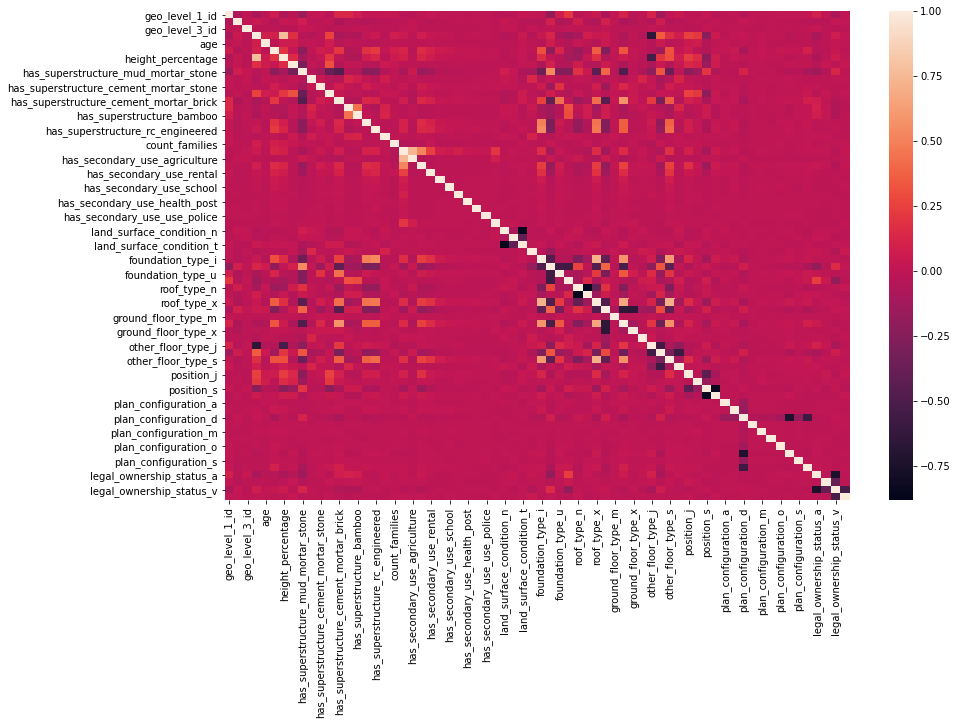

In [8]:
corrMatrix=df.corr()
f=plt.figure(figsize=(14,9))
sns.heatmap(corrMatrix, annot=False)
f.show()

In [9]:
#Korrelation
correlated_features = set()
correlation_matrix = df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]),2)}")
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(f"Drop the following features: {correlated_features}")
df=df.drop(columns=correlated_features)

The following features are correlated: land_surface_condition_t and land_surface_condition_n. Correlation = 0.88
The following features are correlated: roof_type_q and roof_type_n. Correlation = 0.85
The following features are correlated: position_t and position_s. Correlation = 0.82
Drop the following features: {'land_surface_condition_t', 'roof_type_q', 'position_t'}


je nach Modell beachten

# IV. Split dataset back into train and test set


In [6]:
data_train, target_train, data_test = split_data(df)
data_train

# V. Model building - Baselines

## Train-Test-Split

In [10]:
#scale geo_features for logistic regression and runtime
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id','age']
scaler = MinMaxScaler()
data_train[geo_features] = scaler.fit_transform(data_train[geo_features])
data_train

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
802906             0.200000        0.341275        0.970637   
28830              0.266667        0.630694        0.223761   
94947              0.700000        0.254380        0.714013   
590882             0.733333        0.292922        0.850959   
201944             0.366667        0.091801        0.118405   
...                     ...             ...             ...   
688636             0.833333        0.935529        0.128989   
669485             0.566667        0.501051        0.163921   
602512             0.566667        0.035739        0.649558   
151409             0.866667        0.027330        0.147291   
747594             0.700000        0.006307        0.724198   

             count_floors_pre_eq       age  area_percentage  \
building_id                                                   
802906                     0.125  0.030151         0.050505   
28830                      0.125  0.010050         0.070707   
94947                      0.125  0.010050         0.040404   
590882                     0.125  0.010050         0.050505   
201944                     0.250  0.030151         0.070707   
...                          ...       ...              ...   
688636                     0.000  0.055276         0.050505   
669485                     0.125  0.000000         0.050505   
602512                     0.250  0.055276         0.050505   
151409                     0.125  0.010050         0.131313   
747594                     0.250  0.010050         0.060606   

             height_percentage  has_superstructure_adobe_mud  \
building_id                                                    
802906                0.100000                             1   
28830                 0.166667                             0   
94947                 0.100000                             0   
590882                0.100000                             0   
201944                0.233333                             1   
...                        ...                           ...   
688636                0.033333                             0   
669485                0.100000                             0   
602512                0.166667                             0   
151409                0.133333                             0   
747594                0.133333                             0   

             has_superstructure_mud_mortar_stone  \
building_id                                        
802906                                         1   
28830                                          1   
94947                                          1   
590882                                         1   
201944                                         0   
...                                          ...   
688636                                         1   
669485                                         1   
602512                                         1   
151409                                         0   
747594                                         1   

             has_superstructure_stone_flag  \
building_id                                  
802906                                   0   
28830                                    0   
94947                                    0   
590882                                   0   
201944                                   0   
...                                    ...   
688636                                   0   
669485                                   0   
602512                                   0   
151409                                   0   
747594                                   0   

             has_superstructure_cement_mortar_stone  \
building_id                                           
802906                                            0   
28830                                             0   
94947                                       

In [11]:
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42)

## Rebalance Train set

Text(0, 0.5, 'Frequency')

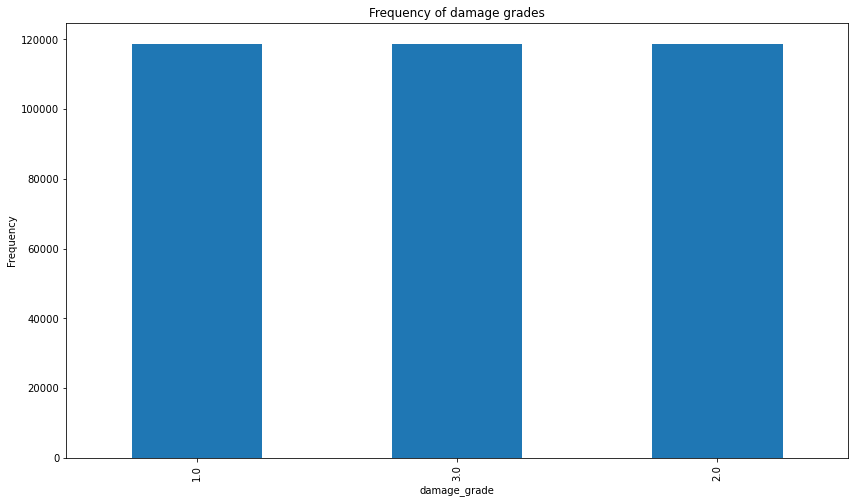

In [12]:
sampler = RandomOverSampler()
train_balanced_data, train_balanced_target = sampler.fit_resample(data_train, target_train)

ax = train_balanced_target.value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Frequency of damage grades")
ax.set_xlabel("damage_grade")
ax.set_ylabel("Frequency")

In [13]:
train_balanced_data

geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  \
0             0.433333        0.180098        0.664598                0.250   
1             0.200000        0.754029        0.732235                0.250   
2             0.233333        0.587246        0.853266                0.125   
3             0.233333        0.388928        0.219862                0.125   
4             0.566667        0.477926        0.082677                0.250   
...                ...             ...             ...                  ...   
356311        0.333333        0.088998        0.104003                0.125   
356312        0.233333        0.432376        0.184053                0.125   
356313        0.333333        0.422565        0.962919                0.125   
356314        0.766667        0.625788        0.132251                0.250   
356315        0.366667        0.536090        0.536087                0.250   

             age  area_percentage  height_percentage  \
0       0.025126         0.010101           0.100000   
1       0.040201         0.090909           0.200000   
2       0.045226         0.070707           0.100000   
3       0.030151         0.060606           0.066667   
4       0.030151         0.050505           0.166667   
...          ...              ...                ...   
356311  0.005025         0.040404           0.100000   
356312  0.000000         0.040404           0.100000   
356313  0.015075         0.090909           0.066667   
356314  0.025126         0.080808           0.166667   
356315  0.070352         0.020202           0.133333   

        has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  \
0                                  1                                    0   
1                                  0                                    1   
2                                  0                                    1   
3                                  0                                    1   
4                                  0                                    1   
...                              ...                                  ...   
356311                             0                                    1   
356312                             0                                    1   
356313                             0                                    1   
356314                             0                                    1   
356315                             0                                    0   

        has_superstructure_stone_flag  has_superstructure_cement_mortar_stone  \
0                                   0                                       0   
1                                   0                                       0   
2                                   0                                       0   
3                                   0                                       1   
4                                   0                                       0   
...                               ...                                     ...   
356311                              0                                       0   
356312                              0                                       0   
356313                              0                                       0   
356314                              0                                       0   
356315                              0                                       0   

        has_superstructure_mud_mortar_brick  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   
...                                     ...   
356311                                    0   
356312                                    0   
356313                                    0   
356314            

# Decision Tree

## ohne Rebalance

In [14]:
dt = DecisionTreeClassifier().fit(data_train,target_train)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6567
The F1-Score micro on test set: 0.6567
The F1-Score macro on test set: 0.6090
The Precision-Score on test set: 0.6567
The Recall-Score on test set: 0.6567
Confusion Matrix : 
[[ 2640  2191   339]
 [ 2340 20863  6284]
 [  355  6384 10725]]


## mit Rebalance

In [15]:
dt = DecisionTreeClassifier().fit(train_balanced_data, train_balanced_target)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6531
The F1-Score micro on test set: 0.6531
The F1-Score macro on test set: 0.6032
The Precision-Score on test set: 0.6531
The Recall-Score on test set: 0.6531
Confusion Matrix : 
[[ 2521  2335   314]
 [ 2243 20793  6451]
 [  323  6417 10724]]


# Logistic Regression

## ohne Rebalance

In [16]:
lr = LogisticRegression(max_iter=10000).fit(data_train, target_train)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.5881
The F1-Score micro on test set: 0.5881
The F1-Score macro on test set: 0.4631
The Precision-Score on test set: 0.5881
The Recall-Score on test set: 0.5881
Confusion Matrix : 
[[ 1524  3518   128]
 [  968 25681  2838]
 [   91 13926  3447]]


## mit Rebalance

In [17]:
lr = LogisticRegression(max_iter=10000).fit(train_balanced_data, train_balanced_target)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

The Accuracy on test set: 0.5069
The F1-Score micro on test set: 0.5069
The F1-Score macro on test set: 0.5046
The Precision-Score on test set: 0.5069
The Recall-Score on test set: 0.5069


## Grid Search

In [24]:
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
# logreg_cv=GridSearchCV(lr,grid,cv=10)
# logreg_cv.fit(data_train, target_train)
# prediction = logreg_cv.predict(data_test)

# print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

# # New Model Evaluation metrics 
# acc = accuracy_score(target_test,prediction) 
# f1_mic= f1_score(target_test,prediction,average='micro') 
# f1_mac= f1_score(target_test,prediction,average='macro') 
# pr= precision_score(target_test,prediction,average='micro') 
# re= recall_score(target_test,prediction,average='micro') 
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
# print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))

# #Logistic Regression (Grid Search) Confusion matrix
# confusion_matrix(target_train,prediction)

C:\Users\Nikla\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Nikla\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nikla\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Nikla\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Nikla\anaconda3\lib\site-packages\sklearn\model_selection\_v

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
The Accuracy on test set: 0.5881
The F1-Score micro on test set: 0.5881
The F1-Score macro on test set: 0.4631
The Precision-Score on test set: 0.5881
The Recall-Score on test set: 0.5881


ValueError: Found input variables with inconsistent numbers of samples: [208480, 52121]

Rebalance nötig?

# SVM

### ohne Rebalance

In [22]:
# sv = SVC(C=1, kernel ='rbf',decision_function_shape='ovo').fit(data_train, target_train)
# prediction = sv.predict(data_test)
# acc = accuracy_score(target_test,prediction) 
# f1_mic= f1_score(target_test,prediction,average='micro') 
# f1_mac= f1_score(target_test,prediction,average='macro') 
# pr= precision_score(target_test,prediction,average='micro') 
# re= recall_score(target_test,prediction,average='micro') 
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
# print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))
# print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6167
The F1-Score micro on test set: 0.6167
The F1-Score macro on test set: 0.5088
The Precision-Score on test set: 0.6167
The Recall-Score on test set: 0.6167
Confusion Matrix : 
[[ 1814  3214   142]
 [ 1006 26051  2430]
 [   78 13110  4276]]


## mit Relabance

In [23]:
# sv = SVC(C=1, kernel ='rbf',decision_function_shape='ovo').fit(train_balanced_data, train_balanced_target)
# prediction = sv.predict(data_test)
# acc = accuracy_score(target_test,prediction) 
# f1_mic= f1_score(target_test,prediction,average='micro') 
# f1_mac= f1_score(target_test,prediction,average='macro') 
# pr= precision_score(target_test,prediction,average='micro') 
# re= recall_score(target_test,prediction,average='micro') 
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
# print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))
# print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.5523
The F1-Score micro on test set: 0.5523
The F1-Score macro on test set: 0.5444
The Precision-Score on test set: 0.5523
The Recall-Score on test set: 0.5523
Confusion Matrix : 
[[ 3600   759   811]
 [ 4545 12569 12373]
 [  672  4173 12619]]


# KNN

In [ ]:
knn = KNeighborsClassifier().fit(data_train,target_train)
prediction = knn.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

In [ ]:
knn = KNeighborsClassifier().fit(train_balanced_data, train_balanced_target)
prediction = knn.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

# VI. Generate Features

In [6]:
df = feature_engineering(df)
df

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0            802906        0.200000        0.341275        0.970637   
1             28830        0.266667        0.630694        0.223761   
2             94947        0.700000        0.254380        0.714013   
3            590882        0.733333        0.292922        0.850959   
4            201944        0.366667        0.091801        0.118405   
...             ...             ...             ...             ...   
347464       310028        0.133333        0.423966        0.288295   
347465       663567        0.333333        0.985985        0.947481   
347466      1049160        0.733333        0.796076        0.613671   
347467       442785        0.200000        0.729502        0.072571   
347468       501372        0.866667        0.025228        0.512135   

        count_floors_pre_eq       age  area_percentage  height_percentage  \
0                     0.125  0.030151         0.050505           0.100000   
1                     0.125  0.010050         0.070707           0.166667   
2                     0.125  0.010050         0.040404           0.100000   
3                     0.125  0.010050         0.050505           0.100000   
4                     0.250  0.030151         0.070707           0.233333   
...                     ...       ...              ...                ...   
347464                0.250  0.070352         0.191919           0.133333   
347465                0.250  0.025126         0.050505           0.166667   
347466                0.000  0.050251         0.020202           0.033333   
347467                0.125  0.005025         0.080808           0.100000   
347468                0.125  0.010050         0.101010           0.066667   

        has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  \
0                                  1                                    1   
1                                  0                                    1   
2                                  0                                    1   
3                                  0                                    1   
4                                  1                                    0   
...                              ...                                  ...   
347464                             0                                    1   
347465                             1                                    1   
347466                             0                                    1   
347467                             1                                    1   
347468                             0                                    0   

        has_superstructure_stone_flag  has_superstructure_cement_mortar_stone  \
0                                   0                                       0   
1                                   0                                       0   
2                                   0                                       0   
3                                   0                                       0   
4                                   0                                       0   
...                               ...                                     ...   
347464                              0                                       0   
347465                              1                                       0   
347466                              0                                       0   
347467                              0                                       0   
347468                              0                                       0   

        has_superstructure_mud_mortar_brick  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   
...                                     ...   
347

In [7]:
#Korrelation
correlated_features = set()
correlation_matrix = df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]),2)}")
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(f"Drop the following features: {correlated_features}")
#drop correlated features
df=df.drop(columns=correlated_features)

The following features are correlated: land_surface_condition_t and land_surface_condition_n. Correlation = 0.88
The following features are correlated: roof_type_q and roof_type_n. Correlation = 0.85
The following features are correlated: position_t and position_s. Correlation = 0.83
The following features are correlated: age_40_100 and age_u_40. Correlation = 0.96
Drop the following features: {'position_t', 'land_surface_condition_t', 'roof_type_q', 'age_40_100'}


## Split data into train and final test again

In [8]:
data_train, target_train, data_test = split_data(df)
data_train

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
802906             0.200000        0.341275        0.970637   
28830              0.266667        0.630694        0.223761   
94947              0.700000        0.254380        0.714013   
590882             0.733333        0.292922        0.850959   
201944             0.366667        0.091801        0.118405   
...                     ...             ...             ...   
688636             0.833333        0.935529        0.128989   
669485             0.566667        0.501051        0.163921   
602512             0.566667        0.035739        0.649558   
151409             0.866667        0.027330        0.147291   
747594             0.700000        0.006307        0.724198   

             count_floors_pre_eq       age  area_percentage  \
building_id                                                   
802906                     0.125  0.030151         0.050505   
28830                      0.125  0.010050         0.070707   
94947                      0.125  0.010050         0.040404   
590882                     0.125  0.010050         0.050505   
201944                     0.250  0.030151         0.070707   
...                          ...       ...              ...   
688636                     0.000  0.055276         0.050505   
669485                     0.125  0.000000         0.050505   
602512                     0.250  0.055276         0.050505   
151409                     0.125  0.010050         0.131313   
747594                     0.250  0.010050         0.060606   

             height_percentage  has_superstructure_adobe_mud  \
building_id                                                    
802906                0.100000                             1   
28830                 0.166667                             0   
94947                 0.100000                             0   
590882                0.100000                             0   
201944                0.233333                             1   
...                        ...                           ...   
688636                0.033333                             0   
669485                0.100000                             0   
602512                0.166667                             0   
151409                0.133333                             0   
747594                0.133333                             0   

             has_superstructure_mud_mortar_stone  \
building_id                                        
802906                                         1   
28830                                          1   
94947                                          1   
590882                                         1   
201944                                         0   
...                                          ...   
688636                                         1   
669485                                         1   
602512                                         1   
151409                                         0   
747594                                         1   

             has_superstructure_stone_flag  \
building_id                                  
802906                                   0   
28830                                    0   
94947                                    0   
590882                                   0   
201944                                   0   
...                                    ...   
688636                                   0   
669485                                   0   
602512                                   0   
151409                                   0   
747594                                   0   

             has_superstructure_cement_mortar_stone  \
building_id                                           
802906                                            0   
28830                                             0   
94947                                       

## split data into train and validation set

In [9]:
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42)

## Rebalance dataset

Text(0, 0.5, 'Frequency')

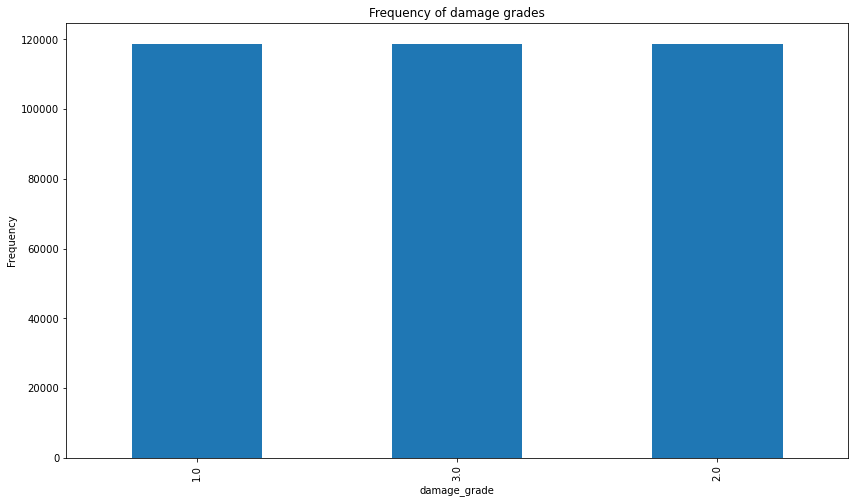

In [10]:
sampler = RandomOverSampler()
train_balanced_data, train_balanced_target = sampler.fit_resample(data_train, target_train)

ax = train_balanced_target.value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Frequency of damage grades")
ax.set_xlabel("damage_grade")
ax.set_ylabel("Frequency")

# VII. Engineered Models without Hyperparameter Tuning

## Decision Tree ohne Rebalance

In [11]:
dt = DecisionTreeClassifier().fit(data_train,target_train)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6568
The F1-Score micro on test set: 0.6568
The F1-Score macro on test set: 0.6082
The Precision-Score on test set: 0.6568
The Recall-Score on test set: 0.6568
Confusion Matrix : 
[[ 2615  2218   337]
 [ 2335 20910  6242]
 [  347  6407 10710]]


## Decision Tree ohne Rebalance

In [12]:
dt = DecisionTreeClassifier().fit(train_balanced_data, train_balanced_target)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6533
The F1-Score micro on test set: 0.6533
The F1-Score macro on test set: 0.6019
The Precision-Score on test set: 0.6533
The Recall-Score on test set: 0.6533
Confusion Matrix : 
[[ 2501  2335   334]
 [ 2267 20807  6413]
 [  368  6353 10743]]


## Logistic Regressin ohne Rebalance

In [13]:
lr = LogisticRegression(max_iter=10000).fit(data_train, target_train)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6355
The F1-Score micro on test set: 0.6355
The F1-Score macro on test set: 0.5446
The Precision-Score on test set: 0.6355
The Recall-Score on test set: 0.6355
Confusion Matrix : 
[[ 1526  3543   101]
 [ 1006 23553  4928]
 [   74  9345  8045]]


## Logistic Regressin mit Rebalance

In [14]:
lr = LogisticRegression(max_iter=10000).fit(train_balanced_data, train_balanced_target)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

The Accuracy on test set: 0.5457
The F1-Score micro on test set: 0.5457
The F1-Score macro on test set: 0.5329
The Precision-Score on test set: 0.5457
The Recall-Score on test set: 0.5457


## xgboost ohne Rebalance

In [17]:
xgb = XGBClassifier(use_label_encoder = True).fit(data_train, target_train)
prediction = xgb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

C:\Users\Nikla\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Nikla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:41:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The Accuracy on test set: 0.7282
The F1-Score micro on test set: 0.7282
The F1-Score macro on test set: 0.6645
The Precision-Score on test set: 0.7282
The Recall-Score on test set: 0.7282


# Featuretools-package

In [15]:
import featuretools as ft

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


2021-05-25 09:40:46,081 featuretools - WARNING    Featuretools failed to load plugin tsfresh from library featuretools_tsfresh_primitives.__init__. For a full stack trace, set logging to debug.
